# Word2Vec Algorithm

This is an implementation of the [Word2Vec algorithm](https://en.wikipedia.org/wiki/Word2vec) using the skip-gram architecture. 
I'm adapting code from a course in Udacity to our problem. The original code is here: https://github.com/udacity/deep-learning-v2-pytorch/tree/master/word2vec-embeddings 

# Readings and Videos

* An easy introduction to Recurrent Neural Networks: https://www.youtube.com/watch?v=UNmqTiOnRfg
* A nice lecture on LSTM, which is the type of RNN used in this algorithm: https://www.youtube.com/watch?v=iX5V1WpxxkY&t=1s

* A really good [conceptual overview](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) of Word2Vec from Chris McCormick 
* [First Word2Vec paper](https://arxiv.org/pdf/1301.3781.pdf) from Mikolov et al.
* [Neural Information Processing Systems, paper](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) with improvements for Word2Vec also from Mikolov et al. This explains their choice for subsampling and negative sampling, which makes the algorithm run much faster.
* Visualizing the dataset: https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d



# Loading Data

In [14]:
from project_helper import TweetData, APIData
from skipgram import get_batches, cosine_similarity, cosine_similarity_sample, SkipGramNeg, NegativeSamplingLoss

from collections import Counter
import numpy as np
import random

import torch
from torch import nn
import torch.optim as optim

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.manifold import TSNE

In [7]:
data = APIData()

In [8]:
# get list of words
words = data.words
print(words[:30])

['celebrity', 'apprentice', 'returns', 'to', 'nbc', 'sunday', 'pm', 'et', 'outstanding', 'list', 'of', 'celebrities', 'season', 'should', 'be', 'the', 'best', 'one', 'yet', 'trump', 'tycoon', 'app', 'for', 'iphone', 'touch', 'its', 'but', 'the', 'advice', 'is']


In [9]:
print("Total words in Trump's tweets: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words in Trump's tweets: 594579
Unique words: 5744


### Dictionaries

- Next, I'm creating two dictionaries to convert words to integers and back again (integers to words). 
- The integers are assigned in descending frequency order, so the most frequent word ("the") is given the integer 0 and the next most frequent is 1, etc. 
- Once we have our dictionaries, the words are converted to integers and stored in the list `int_words`.

In [10]:
vocab_to_int, int_to_vocab = data.vocab_to_int, data.int_to_vocab
int_words = data.int_words

print(int_words[:30])

[280, 176, 1217, 2, 398, 482, 186, 961, 1540, 974, 6, 2483, 273, 73, 13, 0, 90, 69, 383, 16, 5241, 2732, 10, 2941, 687, 141, 55, 0, 831, 5]


## Subsampling

- This part is a suggestion in Google's paper http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdfText to speed up and improve the algorithm, 
- The following explanation is from Udacity: 
- Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

Below we subsample the words in `int_words`. We go through `int_words` and discard each word given the probablility $P(w_i)$ shown above. Note that $P(w_i)$ is the probability that a word is discarded. The subsampled data is assigned to `train_words`.

In [11]:
def subsampling(threshold, int_words):
    word_counts = Counter(int_words)
    total_count = len(int_words)
    freqs = {word: count/total_count for word, count in word_counts.items()}
    p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
    train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]
    return freqs, train_words

## Making batches

Now that our data is in good shape, we need to get it into the proper form to pass it into our network. With the skip-gram architecture, for each word in the text, we want to define a surrounding _context_ and grab all the words in a window around that word, with size $C$. 

From [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $[ 1: C ]$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

get_batches is generator function that returns batches of input and target data for our model.  The idea is that it grabs `batch_size` words from a words list. Then for each of those batches, it gets the target words in a window.

In [12]:
int_text = [i for i in range(20)]
x,y = next(get_batches(int_text, batch_size=4, window_size=5))

print('x\n', x)
print('y\n', y)

x
 [0, 1, 1, 1, 2, 2, 2, 3, 3]
y
 [1, 0, 2, 3, 0, 1, 3, 1, 2]


---
# SkipGram model

We define an [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) and a final, softmax output layer.

An Embedding layer takes in a number of inputs, importantly:
* **num_embeddings** – the size of the dictionary of embeddings, or how many rows you'll want in the embedding weight matrix
* **embedding_dim** – the size of each embedding vector; the embedding dimension

The input words are passed in as batches of input word tokens. This will go into a hidden layer of linear units (our embedding layer, and then into a softmax output layer. We'll use the softmax layer to make a prediction about the context words by sampling.

---
## Negative Sampling

For every example we give the network, we train it using the output from the softmax layer. That means for each input, we're making very small changes to millions of weights even though we only have one true example. This makes training the network very inefficient. We can approximate the loss from the softmax layer by only updating a small subset of all the weights at once. We'll update the weights for the correct example, but only a small number of incorrect, or noise, examples. This is called ["negative sampling"](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). 

There are two modifications we need to make. First, since we're not taking the softmax output over all the words, we're really only concerned with one output word at a time. Similar to how we use an embedding table to map the input word to the hidden layer, we can now use another embedding table to map the hidden layer to the output word. Now we have two embedding layers, one for input words and one for output words. Secondly, we use a modified loss function where we only care about the true example and a small subset of noise examples.

$$
- \large \log{\sigma\left(u_{w_O}\hspace{0.001em}^\top v_{w_I}\right)} -
\sum_i^N \mathbb{E}_{w_i \sim P_n(w)}\log{\sigma\left(-u_{w_i}\hspace{0.001em}^\top v_{w_I}\right)}
$$

This is a little complicated so I'll go through it bit by bit. $u_{w_O}\hspace{0.001em}^\top$ is the embedding vector for our "output" target word (transposed, that's the $^\top$ symbol) and $v_{w_I}$ is the embedding vector for the "input" word. Then the first term 

$$\large \log{\sigma\left(u_{w_O}\hspace{0.001em}^\top v_{w_I}\right)}$$

says we take the log-sigmoid of the inner product of the output word vector and the input word vector. Now the second term, let's first look at 

$$\large \sum_i^N \mathbb{E}_{w_i \sim P_n(w)}$$ 

This means we're going to take a sum over words $w_i$ drawn from a noise distribution $w_i \sim P_n(w)$. The noise distribution is basically our vocabulary of words that aren't in the context of our input word. In effect, we can randomly sample words from our vocabulary to get these words. $P_n(w)$ is an arbitrary probability distribution though, which means we get to decide how to weight the words that we're sampling. This could be a uniform distribution, where we sample all words with equal probability. Or it could be according to the frequency that each word shows up in our text corpus, the unigram distribution $U(w)$. The authors found the best distribution to be $U(w)^{3/4}$, empirically. 

Finally, in 

$$\large \log{\sigma\left(-u_{w_i}\hspace{0.001em}^\top v_{w_I}\right)},$$ 

we take the log-sigmoid of the negated inner product of a noise vector with the input vector. 

To give you an intuition for what we're doing here, remember that the sigmoid function returns a probability between 0 and 1. The first term in the loss pushes the probability that our network will predict the correct word $w_O$ towards 1. In the second term, since we are negating the sigmoid input, we're pushing the probabilities of the noise words towards 0.

### Training

Below is our training loop, and I recommend that you train on GPU, if available.

In [15]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

# Get our noise distribution
threshold = 1e-4 #lowered threshold as used in Word2Vec algorithm since we have smaller sample
freqs, train_words = subsampling(threshold, int_words)
word_freqs = np.array(sorted(freqs.values(), reverse=True))
unigram_dist = word_freqs/word_freqs.sum()
noise_dist = torch.from_numpy(unigram_dist**(0.75)/np.sum(unigram_dist**(0.75)))

#original is 5, skipgram paper suggests up to 20 for small data sets
N_negative_sampling = 7

# instantiating the model
embedding_dim = 100
model = SkipGramNeg(len(vocab_to_int), embedding_dim, noise_dist=noise_dist).to(device)

# using Negative Sampling Loss as our loss function
criterion = NegativeSamplingLoss() 

# Choosing optimzier
optimizer = optim.Adam(model.parameters(), lr=0.003)

# train for some number of epochs
print_every = 200
steps = 0
epochs = 20


for e in range(epochs):
    
    # get our input, target batches
    for input_words, target_words in get_batches(train_words, 512):
        steps += 1
        inputs, targets = torch.LongTensor(input_words), torch.LongTensor(target_words)
        inputs, targets = inputs.to(device), targets.to(device)
        
        # input, output, and noise vectors
        input_vectors = model.forward_input(inputs)
        output_vectors = model.forward_output(targets)
        noise_vectors = model.forward_noise(inputs.shape[0], N_negative_sampling)

        # negative sampling loss
        loss = criterion(input_vectors, output_vectors, noise_vectors)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss stats
        if steps % print_every == 0:
            print("Epoch: {}/{}".format(e+1, epochs))
            print("Loss: ", loss.item()) # avg batch loss at this point in training
            valid_examples, valid_similarities = cosine_similarity(model.in_embed, device=device)
            _, closest_idxs = valid_similarities.topk(6)

            valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
            for ii, valid_idx in enumerate(valid_examples):
                closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
                print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
            print("...\n")

Epoch: 1/20
Loss:  8.2781982421875
why | coalition, ayrshire, neighborhood, michigan, lynch
going | costly, stop, over, another, potomac
be | whether, failing, traitor, magnificent, michael
t | investment, first, issue, offers, spied
there | football, into, himself, terrorists, possibly
so | fresh, windmills, golden, clubhouse, gotten
d | him, link, would, wash, answer
what | dollar, greats, measure, standing, tips
thursday | apply, fails, syria, shot, server
fraud | economics, fabulous, closed, deserves, untrue
enjoyed | youth, spell, ireland, falling, negotiator
members | nuclear, funding, scandal, harassment, salute
hearing | appreciated, habit, wife, french, werent
king | wig, use, prescription, delaware, loaded
judge | hacked, leakin, line, costing, february
ur | were, journalist, cno, architectural, novi
...

Epoch: 1/20
Loss:  5.221885681152344
a | and, reporting, completely, secrets, really
like | let, do, pretend, plus, completely
it | and, have, avoid, people, office
this | r

king | was, apologizing, bilateral, followed, tomorrow
private | dining, pool, featuring, deficit, pays
anti | witch, probe, hunt, americans, pre
mean | fast, exercise, focused, schools, election
group | incorrectly, sr, another, albert, order
businessman | true, sir, please, business, give
player | minute, football, thing, villa, super
sanders | bernie, judgement, rigged, supporters, total
...

Epoch: 12/20
Loss:  2.691086769104004
how | too, tweet, wonder, watching, so
president | mr, runs, run, please, if
like | you, that, man, what, too
do | i, you, up, but, might
obama | why, should, must, isis, their
for | great, i, s, to, a
no | the, that, he, definition, does
m | show, i, nbc, tune, fan
named | luxury, golf, designed, congratulations, spectacular
king | was, followed, bilateral, apologizing, assembly
brilliant | mr, run, hope, please, sir
situation | ebola, blow, lt, protect, something
benghazi | costs, attack, investigating, midterms, libya
enjoyed | you, wise, mark, i, night


# Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.
Wiki on T-SNE, a bit complicated! https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

In [16]:
# getting embeddings from the embedding layer of our model, by name
embeddings = model.in_embed.weight.to('cpu').data.numpy()

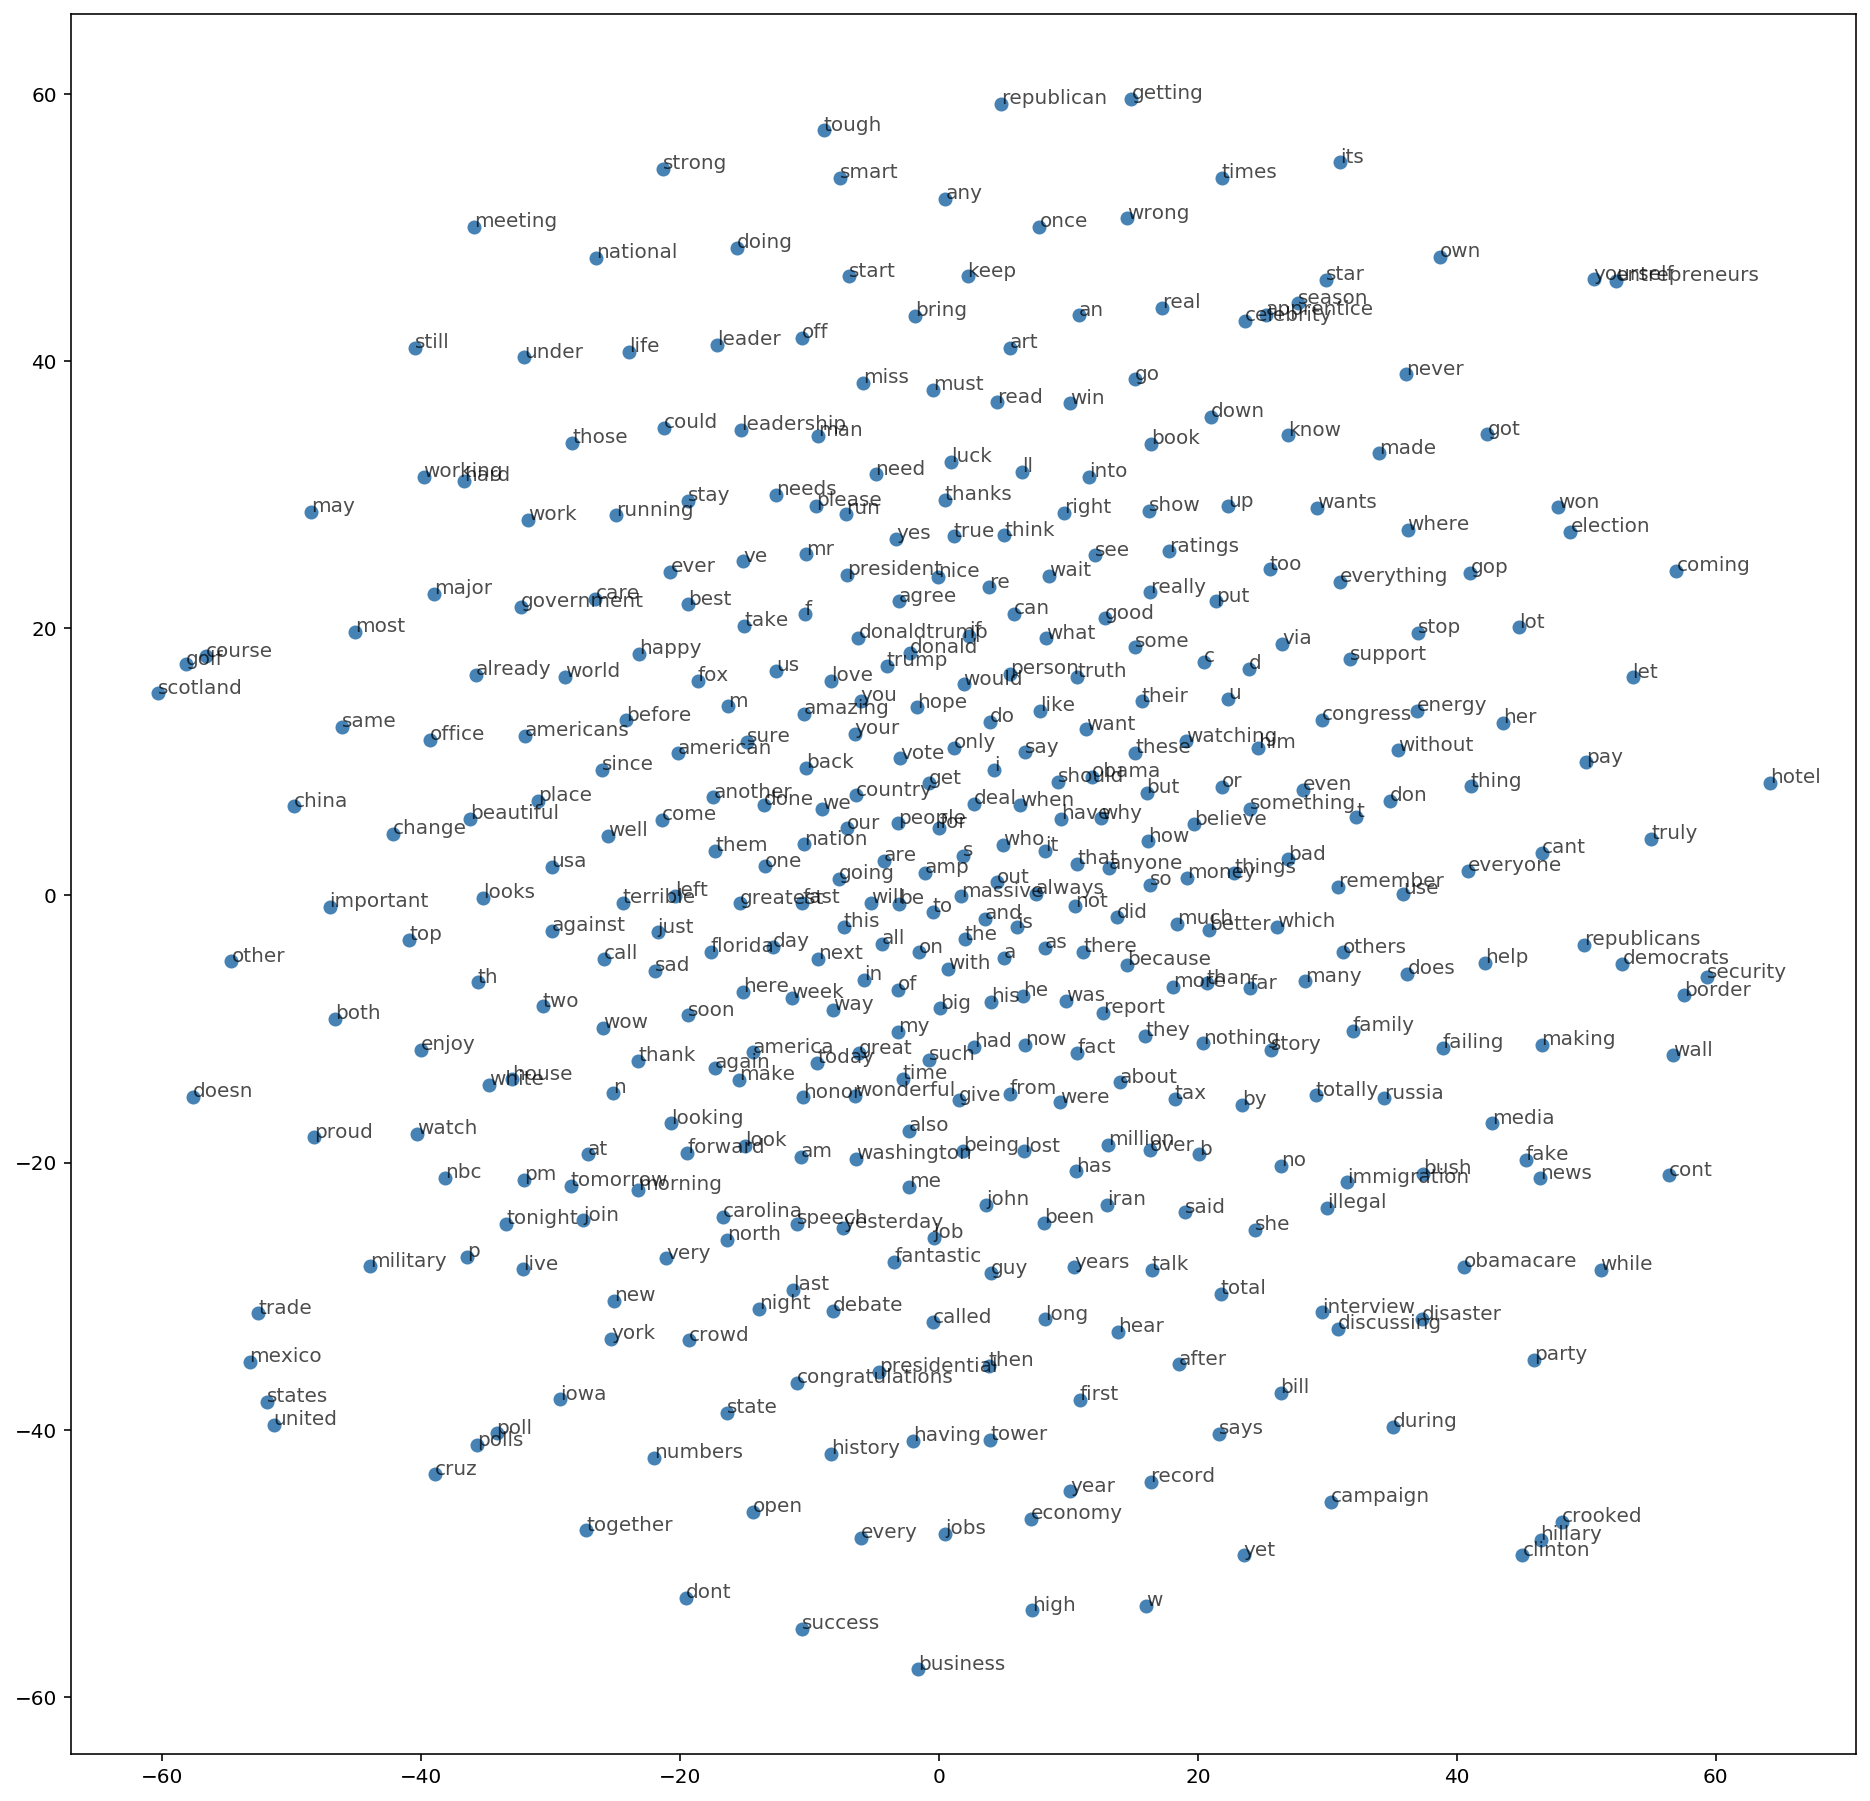

In [17]:
viz_words = 400
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

---
## Cosine Similarity

$$
\mathrm{similarity} = \cos(\theta) = \frac{\vec{a} \cdot \vec{b}}{|\vec{a}||\vec{b}|}
$$


We can encode the validation words as vectors $\vec{a}$ using the embedding table, then calculate the similarity with each word vector $\vec{b}$ in the embedding table. With the similarities, we can print out the validation words and words in our embedding table semantically similar to those words. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.

In [18]:
def word_similarities(word, num):
    word_int = vocab_to_int[word]
    valid_examples, valid_similarities = cosine_similarity_sample(model.in_embed, [word_int])
    closest_idxs = valid_similarities.topk(num)
    closest_words = [int_to_vocab[int(a)] for a in closest_idxs.indices[0]]
    return closest_words

In [19]:
word_similarities('tariff',20)

['tariff',
 'barriers',
 'tariffs',
 'nato',
 'european',
 'products',
 'pouring',
 'protection',
 'united',
 'jinping',
 'amounts',
 'china',
 'mexico',
 'productive',
 'union',
 'xf',
 'xi',
 'engagement',
 'trade',
 'apple']

In [20]:
keys = ['collusion', 'hillary', 'hotel', 'democrats', 'campaign', 'fed', 'china', 'mexico', 'tariffs']


In [21]:
# Code adapted from 
# https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d
def get_clusters(keys, num, embeddings):
    embedding_clusters = []
    word_clusters = []
    for word in keys:
        embed_sub = []
        words = []
        for similar_word in word_similarities(word,20):
            words.append(similar_word)
            embed_sub.append(embeddings[vocab_to_int[similar_word],:])
        embedding_clusters.append(embed_sub)
        word_clusters.append(words)
    return embedding_clusters, word_clusters
    

In [22]:
embedding_clusters, word_clusters = get_clusters(keys,10,embeddings)

In [23]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

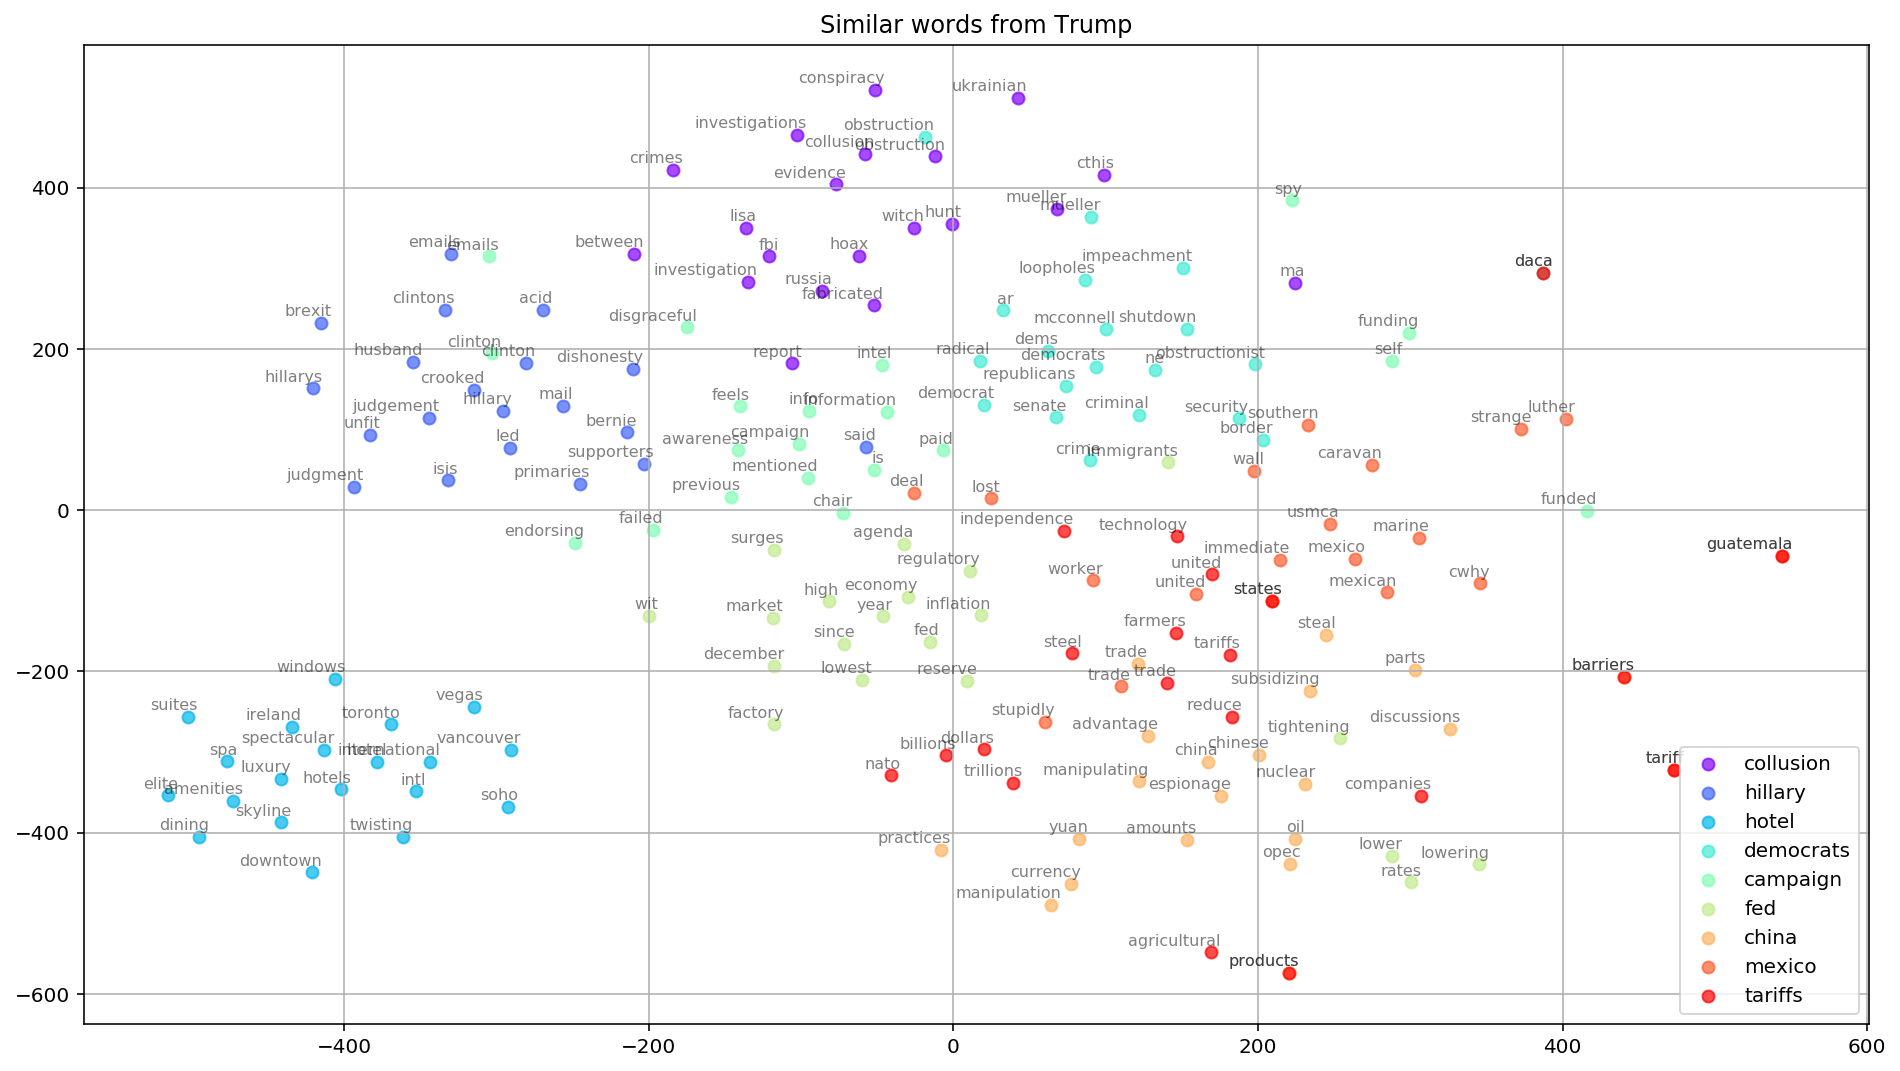

In [24]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words from Trump', keys, embeddings_en_2d, word_clusters, 0.7,
                        'results/similar_words.png')
